<a href="https://colab.research.google.com/github/Shakir-ahmed1/colab_notebooks/blob/main/tigrigna_stt/Tigrigna_STT_finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==================== Setup & Dependencies ====================
!pip install git+https://github.com/openai/whisper.git
!pip install torchaudio librosa datasets jiwer evaluate
!apt-get install -y ffmpeg


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-1oda5bvx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-1oda5bvx
  Resolved https://github.com/openai/whisper.git to commit dd985ac4b90cafeef8712f2998d62c59c3e62d22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━

In [ ]:

import os
import shutil
import subprocess
import sys
import gdown

def install_unrar():
    print("Installing 'unrar' utility...")
    try:
        !apt-get update > /dev/null 2>&1
        !apt-get install unrar -y > /dev/null 2>&1
        print("'unrar' installed successfully.")
    except Exception as e:
        print(f"Error installing 'unrar': {e}")
        sys.exit(1)

def download_from_drive(share_url, output_path):
    try:
        file_id = share_url.split('/d/')[1].split('/')[0]
        gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)
        print(f"Downloaded file to {output_path}")
    except Exception as e:
        print(f"Error downloading from Google Drive: {e}")
        sys.exit(1)

def extract_rar_file(file_path, extract_to):
    print(f"Extracting {file_path} to {extract_to}")
    try:
        if os.path.exists(extract_to):
            shutil.rmtree(extract_to)
            print(f"Deleted existing directory at {extract_to}")
        os.makedirs(extract_to, exist_ok=True)
        result = subprocess.run(['unrar', 'x', '-y', file_path, extract_to + '/'],
                                capture_output=True, text=True)
        if result.returncode == 0:
            print(f"Extracted {file_path} to {extract_to}")
        else:
            raise RuntimeError(result.stderr)
    except Exception as e:
        print(f"Error extracting {file_path}: {e}")

install_unrar()

# rar_url = 'https://drive.google.com/file/d/1JR3CBp_gWAv5FtgSbb9eM76k63ivxNJh/view?usp=sharing' # preprocessed tigrigna dataset
rar_url = 'https://drive.google.com/file/d/1225Iece2OEAGwYVLlbfJ1eWBhMDkbaq1/view?usp=sharing' # AmharicSpeechCorpus Magdeburg
local_rar_path = '/content/preprocessed_dataset.rar'
extract_to_path = '/content/preprocessed_dataset'

download_from_drive(rar_url, local_rar_path)
extract_rar_file(local_rar_path, extract_to_path)




Installing 'unrar' utility...
'unrar' installed successfully.


Downloading...
From (original): https://drive.google.com/uc?id=1225Iece2OEAGwYVLlbfJ1eWBhMDkbaq1
From (redirected): https://drive.google.com/uc?id=1225Iece2OEAGwYVLlbfJ1eWBhMDkbaq1&confirm=t&uuid=80df432d-9295-495d-b90c-1e153cda825f
To: /content/preprocessed_dataset.rar
100%|██████████| 7.74G/7.74G [01:44<00:00, 74.1MB/s]


Downloaded file to /content/preprocessed_dataset.rar
Extracting /content/preprocessed_dataset.rar to /content/preprocessed_dataset
Extracted /content/preprocessed_dataset.rar to /content/preprocessed_dataset


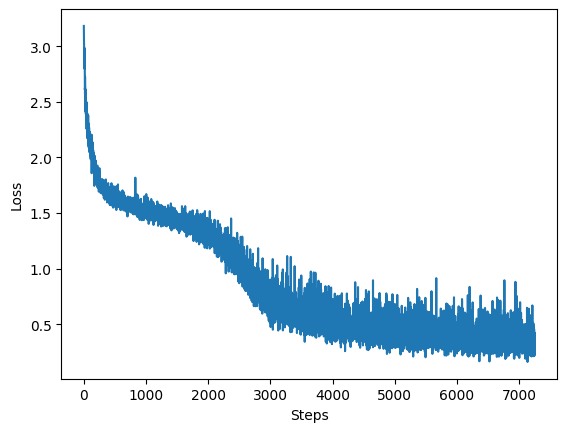

Epoch 1: 100%|██████████| 7261/7261 [2:25:57<00:00,  1.21s/it]


Checkpoint saved to /content/drive/MyDrive/shared_with_me/whisper_lora_tigrigna/checkpoint.pth


Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipython-input-1-815041814.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():  # Use autocast for evaluation
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating: 100%|██████████| 74/74 [11:21<00:00,  9.20s/it]


Epoch 1 WER: 92.53%
✅ Final model saved.

🔍 Running inference on test samples...


/tmp/ipython-input-1-815041814.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():  # Use autocast for inference


▶ Sample 0:
True : ሃም ድልየትይ ኣታሓሳስባይ እቲ ማሕበረሰብ ምስኡ ላትቓየረ ይኡ ድኸድ ካብ ግዜ ዳብ ግዜ
Pred.: ካምድብቲ ያተሓሳስባይት ምሕሕበረሰም ምስብላት ቓይየር ይድኽት ከግዜ ረግዜ

▶ Sample 1:
True : ስለዚ መኪና ክገዝእ ኣይኸእልን
Pred.: ስለዚ መኪና ገዛ ይኽልን

▶ Sample 2:
True : ኣብ ከተማ የለይ
Pred.: ምልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልልል

▶ Sample 3:
True : መንግስቲ ኣመሪካ ነታ መርከብ ዝሓለፈ ዓርቢ እዩ ኣብ ፀሊም መዝገብ ኣስፊርዋ
Pred.: መንግስተ ኣመሪካ ነታ መርክክብ ዘሓለፋዕርቢ እዩ ኣብፀሊ መዝገብ ኣስፍይርዋ

▶ Sample 4:
True : ሐዚ ድኣብነት ሐዚ ድኾነ መዋጮ እንድሒ ሃልዩ ሃምዚ ናሴራ መዋጮ
Pred.: ሕዝደ ኣብነት ሕዝኡ እቲ ኽን መዋጡን ሓልዩ ሃም ዝና ሲራ መዋጡኡ



Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 1024). Running this sequence through the model will result in indexing errors


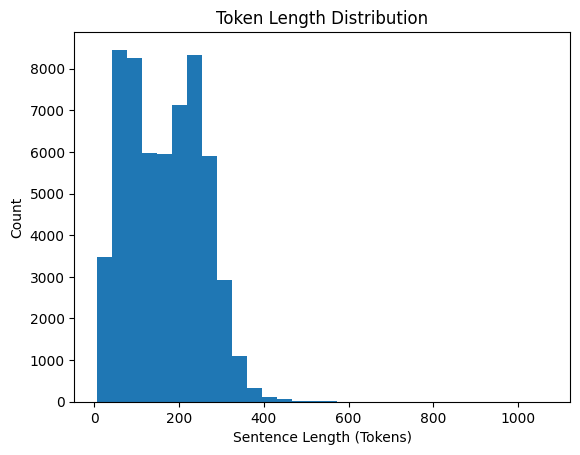

In [1]:
# ==================== Dataset & Preprocessing ====================
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
from peft import LoraConfig, get_peft_model, PeftModel
import evaluate
import librosa
from IPython.display import clear_output
from torch.cuda.amp import autocast, GradScaler  # Added for mixed precision

shared_drive_dir = "/content/drive/MyDrive/shared_with_me/whisper_lora_amharic"
os.makedirs(shared_drive_dir, exist_ok=True)
checkpoint_path = os.path.join(shared_drive_dir, "checkpoint.pth")

dataset_dir = '/content/preprocessed_dataset/AmharicSpeechCorpus-magdeburg-uni/dataset'
tsv_file_path = os.path.join(dataset_dir, 'data.tsv')
audio_dir = os.path.join(dataset_dir, 'recordings')

if not os.path.exists(tsv_file_path) or not os.path.exists(audio_dir):
    print("Dataset missing. Exiting.")
    sys.exit(1)

df = pd.read_csv(tsv_file_path, sep='\t', encoding='utf-8')
df['path'] = df['path'].apply(lambda x: os.path.join(audio_dir, os.path.basename(x)))
# df = df.head(200)
dataset = Dataset.from_pandas(df)
train_test_split = dataset.train_test_split(test_size=0.01, seed=42)
train_data = train_test_split['train']
test_data = train_test_split['test']

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='amharic', task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "v_proj", "out_proj"],
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(model, lora_config)

class WhisperTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len=300):
        self.dataset = dataset
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        try:
            audio_data, _ = librosa.load(item['path'], sr=16000)
        except:
            audio_data = np.zeros(16000)
        input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features[0]
        labels = tokenizer(item['text'], padding="max_length", max_length=self.max_len,
                           truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)[0][1:]
        return {"input_features": input_features, "labels": labels}

train_dataset = WhisperTrainingDataset(train_data)
test_dataset = WhisperTrainingDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# ==================== Evaluation & Checkpoint Functions ====================
wer_metric = evaluate.load("wer")

def evaluate_model(model, dataloader):
    model.eval()
    predictions, references = [], []
    for batch in tqdm(dataloader, desc="Evaluating"):
        input_features = batch["input_features"].to('cuda')
        labels = batch["labels"].to('cuda')
        with torch.no_grad(), autocast():  # Use autocast for evaluation
            generated_tokens = model.generate(input_features=input_features, language='amharic', task='transcribe')
        predictions += tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        references += tokenizer.batch_decode(labels, skip_special_tokens=True)
    return wer_metric.compute(predictions=predictions, references=references) * 100

def save_checkpoint(model, optimizer, scaler, epoch, global_step, loss):  # Modified to include scaler
    torch.save({
        'epoch': epoch,
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),  # Save scaler state
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(model, optimizer, scaler):  # Modified to include scaler
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])  # Load scaler state
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1}, step {checkpoint['global_step']}")
        return checkpoint['epoch'], checkpoint['global_step'], checkpoint['loss']
    print("No checkpoint found, starting fresh.")
    return 0, 0, None

# ==================== Training ====================
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scaler = GradScaler()  # Initialize GradScaler for mixed precision
max_epochs = 2
running_loss, running_wer = [], []
global_step = 0
steps_per_epoch = len(train_dataloader)
checkpoint_interval = 100

start_epoch, global_step, last_loss = load_checkpoint(model, optimizer, scaler)  # Pass scaler
if start_epoch > 0:
  start_epoch += 1
if last_loss: running_loss.append(last_loss)

batches_to_skip = global_step % steps_per_epoch if global_step > 0 else 0

for epoch in range(start_epoch, max_epochs):
    batch_iterator = iter(train_dataloader)
    if epoch == start_epoch:
        for _ in range(batches_to_skip): next(batch_iterator, None)

    for batch in tqdm(batch_iterator, desc=f"Epoch {epoch+1}"):
        model.train()
        input_features = batch["input_features"].to('cuda')
        labels = batch["labels"].to('cuda')
        with autocast():  # Enable mixed precision
            loss = model(input_features, labels=labels).loss
        scaler.scale(loss).backward()  # Scale loss before backward
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update scaler for next iteration
        optimizer.zero_grad()
        global_step += 1
        running_loss.append(loss.item())

        if global_step % 50 == 0:
            plt.plot(running_loss)
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            clear_output(wait=True)
            plt.show()

        # if global_step % 100 == 0:
        #     model.save_pretrained(os.path.join(shared_drive_dir, "lora_model_amharic"))
        #     save_checkpoint(model, optimizer, scaler, epoch, global_step, loss.item())  # Pass scaler

    save_checkpoint(model, optimizer, scaler, epoch, global_step, loss.item())  # Pass scaler
    wer = evaluate_model(model, test_dataloader)
    running_wer.append(wer)
    print(f"Epoch {epoch+1} WER: {wer:.2f}%")
    torch.cuda.empty_cache()

# ==================== Save Final Model ====================
model.save_pretrained(os.path.join(shared_drive_dir, "lora_model_amharic_final"))
print("✅ Final model saved.")

# ==================== Inference Examples ====================
print("\n🔍 Running inference on test samples...")
model.eval()
for idx in range(min(5, len(test_data))):
    item = test_data[idx]
    audio_data, _ = librosa.load(item['path'], sr=16000)
    input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')
    with torch.no_grad(), autocast():  # Use autocast for inference
        generated_tokens = model.generate(input_features, language='amharic', task='transcribe')
    text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    print(f"▶ Sample {idx}:\nTrue : {item['text']}\nPred.: {text_pred}\n")

# ==================== Visualize Token Lengths ====================
token_lengths = [len(tokenizer(text).input_ids) for text in train_data['text']]
plt.hist(token_lengths, bins=30)
plt.xlabel("Sentence Length (Tokens)")
plt.ylabel("Count")
plt.title("Token Length Distribution")
plt.show()


🔍 Running inference on 5 random test samples...
▶ Sample 1:
True : ደስታዬም በምድሩ ተድላዬም በሰው ልጆች ነበረ አሁንም ልጆቼ ሆይ ስሙኝ መንገዴንም የሚጠብቁ ምስጉኖች ናቸው ትምህርቴን ስሙ ጠቢባንም ሁኑ ቸል አትበሉትም 
Pred.: ደስታዬም በምድሩ ተድላዬም በሰው ልጆች ነበረ አሁንም ልጆች የሆይ ስሙኝ መንገዴንም የሚጠብቁ ምስግኖች ናቸው ተምርቴን ስሙ ጠቢባንም ሁኑ ቸላት በሉትም 

▶ Sample 2:
True : ነገር ግን ሕዝቤ ክብሩን ለማይረባ ነገር ለወጠ ሰማያት ሆይ በዚህ ተደነቁ እጅግም ደንግጡና ተንጥቀጡ ይላል እግዚአብሔር ሕዝቤ ሁለቱን ክፉ ነገሮች አድርገዋልና 
Pred.: ነገር ግን ሕዝቤ ክብሩን ለማይረባ ነገር ለወጠ ሰማያት ሆይ በዚህ ተደነቁ እጅግም ደንግጡና ተንቀጥቀጡ ይላል እግዚአብሔር ሕዝቤ ሁለቱን ክፉ ነገሮች አድር ገዋልና 

▶ Sample 3:
True : እነሆ ሌዋውያንን ወንድሞቻችሁን ከእስራኤል ልጆች መካከል ወስጄአለሁ የመገናኛውን ድንኳን አገልግሎት ያደርጉ ዘንድ ለእግዚአብሔር የተሰጡ ለእናንተ ስጦታ ናቸው
Pred.: እንሆ ሌዋውያውያንን ወንድሞ ቻችሁን ከእስራኤል ልጆች መካከል ሦስጃለሁ የመገናኛውን እንኳናገል ግሎት ያደርጉ ዘንድ ለእግዚአብሔር የተሰጡ ለእናን ተስጦታናቸው 

▶ Sample 4:
True : ዋቱ ዋቴ በተሰኘዉ ፊልሞ የተለያዩ እምነት ተከታዮች ለህይወታቸዉ ስጋት ላይ ወድቀዉ አንዱ ለአንዱ ተገን ሆኖ ሲፋለም ያሳያል
Pred.: ዋቱ ዋት በትሰኛው ፊልም የትለያዩ እምነትን የሚከተሉ ሰዎች ለህ ወታቸው ስጋት ላይ ወድቀው አንዱ ላንዱ ተገን ሆኖ ሲፋለም ያሳያል 

▶ Sample 5:
True : አድማጯ በጣም ስላደ ነቃት ባደረባቸው የቅናት መንፈስ ተገፋፍተው በመኪና ገጯት 
Pred.: አ

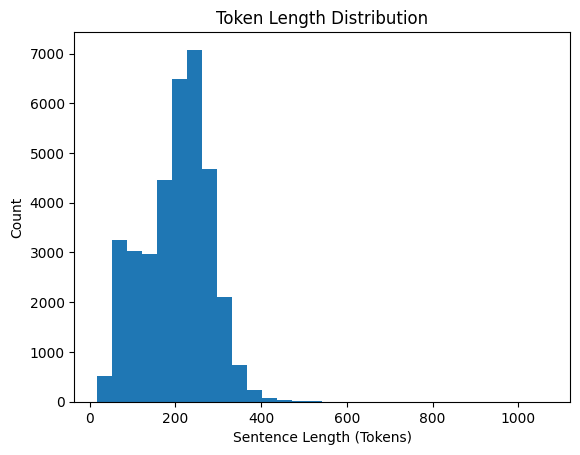

In [ ]:

# # ==================== Inference Examples ====================
# print("\n🔍 Running inference on test samples...")
# model.eval()
# for idx in range(min(5, len(test_data))):
#     item = test_data[idx]
#     audio_data, _ = librosa.load(item['path'], sr=16000)
#     input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')
#     with torch.no_grad():
#         generated_tokens = model.generate(input_features, language='amharic', task='transcribe')
#     text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
#     print(f"▶ Sample {idx}:\nTrue : {item['text']}\nPred.: {text_pred}\n")

# ==================== Inference Examples ====================
import random

print("\n🔍 Running inference on 5 random test samples...")
model.eval()

random_samples = random.sample(list(test_data), k=5)

for idx, item in enumerate(random_samples):
    try:
        audio_data, _ = librosa.load(item['path'], sr=16000)
        input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features.to('cuda')

        with torch.no_grad():
            generated_tokens = model.generate(input_features, language='amharic', task='transcribe')

        text_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
        print(f"▶ Sample {idx + 1}:\nTrue : {item['text']}\nPred.: {text_pred}\n")

    except Exception as e:
        print(f"⚠️ Error processing sample {idx + 1}: {e}")


# ==================== Visualize Token Lengths ====================
token_lengths = [len(tokenizer(text).input_ids) for text in train_data['text']]
plt.hist(token_lengths, bins=30)
plt.xlabel("Sentence Length (Tokens)")
plt.ylabel("Count")
plt.title("Token Length Distribution")
plt.show()